In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os
import soundfile as sf
import random
import pickle

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

In [2]:
# constants
HOP_LENGTH = 256
MONO = 22050
SAMPLE_RATE = 16000
FRAME_SIZE = 512
OVERLAP_RATIO=0.3

In [3]:
x_train_dir = 'x_train_noised_speech'
y_train_dir = 'y_train_clean_audio'

In [4]:
# getting the maximum shape of the numpy array

def get_max_shape(dir):
    max_y = 0
    max_x = 0
    for filename in os.listdir(dir):
        if filename.endswith(".npy"):
            file_path = os.path.join(dir, filename)

            # Load the .npy file and append it to the x_train list
            spectrogram = np.load(file_path)
            if spectrogram.shape[1] > max_y:
                max_y = spectrogram.shape[1]

            if spectrogram.shape[0] > max_x:
                max_x = spectrogram.shape[0]

    return (max_x, max_y)

In [5]:
final_shape = get_max_shape(x_train_dir)

def get_array(dir, final_shape):
    # Initialize an empty list to store the loaded spectrograms
    arr = []
    # Iterate through each file in the directory
    for filename in os.listdir(dir):
        if filename.endswith(".npy"):
            file_path = os.path.join(dir, filename)

            # Load the .npy file and append it to the x_train list
            spectrogram = np.load(file_path)
            # Pad the spectrogram to match the desired final shape
            if spectrogram.shape[1] < final_shape[1]:
                # Pad the spectrogram to match the desired final shape
                pad_width = ((0, 0), (0, final_shape[1] - spectrogram.shape[1]))
                processed_spectrogram = np.pad(spectrogram, pad_width, mode='constant', constant_values=0)
            elif spectrogram.shape[1] > final_shape[1]:
                # Trim the spectrogram to match the desired final shape
                processed_spectrogram = spectrogram[:, :final_shape[1]]
            else:
                processed_spectrogram = spectrogram  # No change needed if the shape is already as desired
            # Append the padded spectrogram to the x_train list
            arr.append(processed_spectrogram)

    # Convert the list to a NumPy array if required
    arr = np.array(arr)

    return arr

In [6]:
x_train = get_array(x_train_dir, final_shape)
x_train.shape

(7, 257, 251)

In [7]:
x_train[0]

array([[0.68712723, 0.67494345, 0.72468936, ..., 0.        , 0.        ,
        0.        ],
       [0.6737151 , 0.6064947 , 0.7042389 , ..., 0.        , 0.        ,
        0.        ],
       [0.63829195, 0.5404151 , 0.55240023, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.11340527, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.11645889, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.12437133, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [9]:
def plot_spect(y):
    # Plot the mel spectogram
    fig, ax = plt.subplots(figsize=(10, 5))
    img = librosa.display.specshow(y,
                                x_axis='time',
                                y_axis='log',
                                ax=ax)
    ax.set_title('Spectogram Example', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

In [24]:
test_spec1 = x_train[0][1:, :]
test_spec2 = x_train[0][:256, :]
test_spec2.shape

(256, 251)

Remove last row 

In [30]:
x_train[0][-1]

array([0.12437133, 0.        , 0.        , 0.6247362 , 0.5217466 ,
       0.        , 0.2551268 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.15544724, 0.07709317, 0.11201801,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.14705057, 0.19683447, 0.1354754 , 0.11249094,
       0.08054523, 0.        , 0.00729294, 0.        , 0.        ,
       0.        , 0.1345152 , 0.09667959, 0.17517658, 0.08466949,
       0.08560286, 0.03194785, 0.03015523, 0.01687283, 0.13318606,
       0.12627038, 0.03918381, 0.03563309, 0.06849184, 0.        ,
       0.        , 0.        , 0.06474328, 0.23691145, 0.        ,
       0.00271392, 0.        , 0.        , 0.03253632, 0.22718997,
       0.08630176, 0.2616237 , 0.13895293, 0.51452446, 0.54370105,
       0.33811712, 0.60704565, 0.2677528 , 0.15705228, 0.09313302,
       0.18690339, 0.22361016, 0.4219717 , 0.22924384, 0.27538437,
       0.23565765, 0.16643076, 0.        , 0.03921032, 0.     

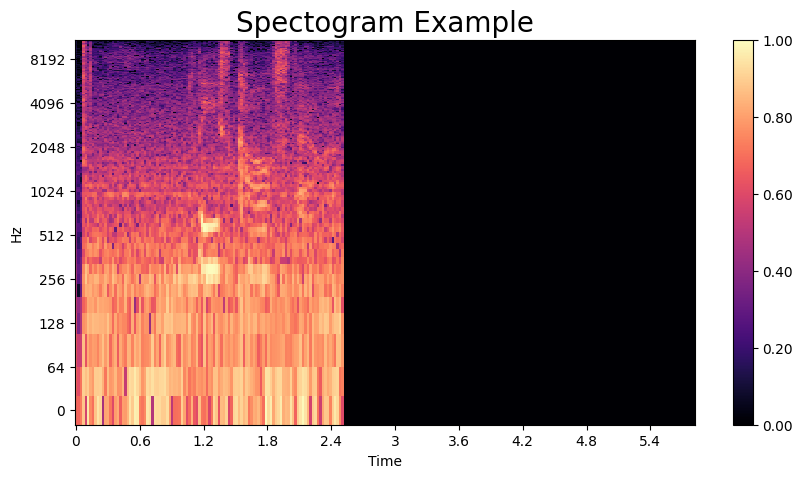

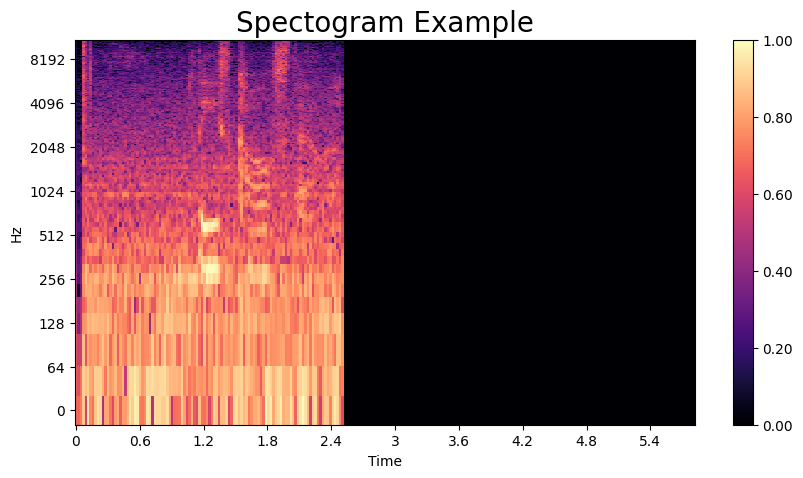

In [25]:
plot_spect(x_train[0])
plot_spect(test_spec2)

In [17]:
# 2. Obtain the corresponding min max value of the loaded spectrogram
def get_min_max_values(file_path, min_max_values):
    min_val = min_max_values[file_path]['min']
    max_val = min_max_values[file_path]['max']
    return min_val, max_val

def denormalize(spectrogram, min_val, max_val):
    denormalized_spectrogram = spectrogram * (max_val - min_val) + min_val
    return denormalized_spectrogram

# 4. Convert spectrogram to audio signal
def spectrogram_to_audio(spectrogram):
    spectrogram = librosa.db_to_amplitude(spectrogram)
    audio_signal = librosa.istft(spectrogram, hop_length=HOP_LENGTH)
    return audio_signal

In [20]:
file_path = 'min_max_value_save\min_max_values.pkl'
with open(file_path, 'rb') as f:
        min_max_values = pickle.load(f)

spec_path = 'x_train_noised_speech\p234_001.wav_spec.npy'

In [26]:
min_val, max_val = get_min_max_values(spec_path, min_max_values)
denorm_spectrogram =denormalize(test_spec2, min_val, max_val)
audio = spectrogram_to_audio(denorm_spectrogram)
audio

array([ 2.5730515e-05,  5.8381220e-06, -3.4938708e-05, ...,
        3.2365988e-21,  0.0000000e+00,  0.0000000e+00], dtype=float32)

In [27]:
sf.write('removed_row_last.wav', audio, samplerate= SAMPLE_RATE)
constructed_audio = glob('*.wav')
constructed_audio

['clean_constructed.wav',
 'constructed.wav',
 'constructed1.wav',
 'lessthan_constructed.wav',
 'padded_constructed.wav',
 'padded_constructed1.wav',
 'removed_row.wav',
 'removed_row_last.wav',
 'stft_constructed_clean.wav']

In [28]:
ipd.Audio(constructed_audio[-2])